# Let's have a look at the training data that we've used to train our network

In [1]:
# sirf functionality
from sirf.STIR import AcquisitionSensitivityModel, AcquisitionModelUsingRayTracingMatrix, ImageData, AcquisitionData, MessageRedirector
from sirf.Utilities import examples_data_path # for our example data

# DataLoaders for Pytorch and some of the functions used
from odl_funcs.ellipses import EllipsesDataset
from odl_funcs.misc import random_phantom, affine_transform_2D_image, affine_transform_2D

# plotting
import matplotlib.pyplot as plt

# for path handling
import os

# pytorch
import torch

In [2]:
# set-up redirection of STIR messages to files
msg_red = MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

# big plots
plt.rcParams['figure.dpi'] = 200

In [3]:
# some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

In order to simulate some random body-ish phantoms, I have decided to use random ellipses. These look something like this:

In [4]:
def normalise_image(image):
    """Normalise image to range [0,1]"""
    image = image - image.min()
    image = image / image.max()
    return image

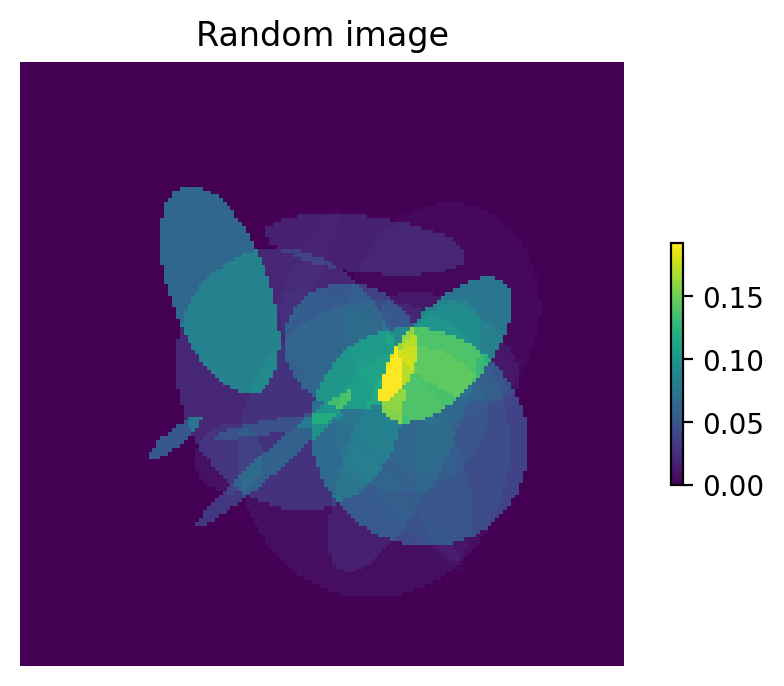

In [5]:
random_image_array = normalise_image(random_phantom((1, 155,155), 25))*2*0.096 # this uses a pseuso-2D shape hence the 1 in the first dimension
plot_2d_image([1,1,1], random_image_array[0], "Random image")

OK so how do we train our network with this? We need to make ourselves a sensitivity image. The following is taken from the EllipsesDataset class in the odl_funs directory (it's been edited a bit). It takes an attenuation image and returns a sensitivity image

In [6]:
radon_transform = AcquisitionModelUsingRayTracingMatrix()

def get_sensitivity(attenuation_image, template):
    # Forward project image then add noise
    acq_model = AcquisitionModelUsingRayTracingMatrix()
    asm_attn = AcquisitionSensitivityModel(attenuation_image, radon_transform)
    asm_attn.set_up(template)
    acq_model.set_acquisition_sensitivity(asm_attn)
    acq_model.set_up(template, attenuation_image)
    y = acq_model.backward(template.get_uniform_copy(1.0))
    return y

In order to set up out acquisition model, we need a template sinogram in order to tell sirf what kind of scanner we'll be using (e.g number of projections, voxel sizes...)

In [7]:
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')
template_sino = AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))
template_image = ImageData(os.path.join(data_path, 'emission.hv'))

OK so let's now construct a SIRF ImageData Object with out random ellipse array from our template image. We'll then find the sensitivity image and plot it

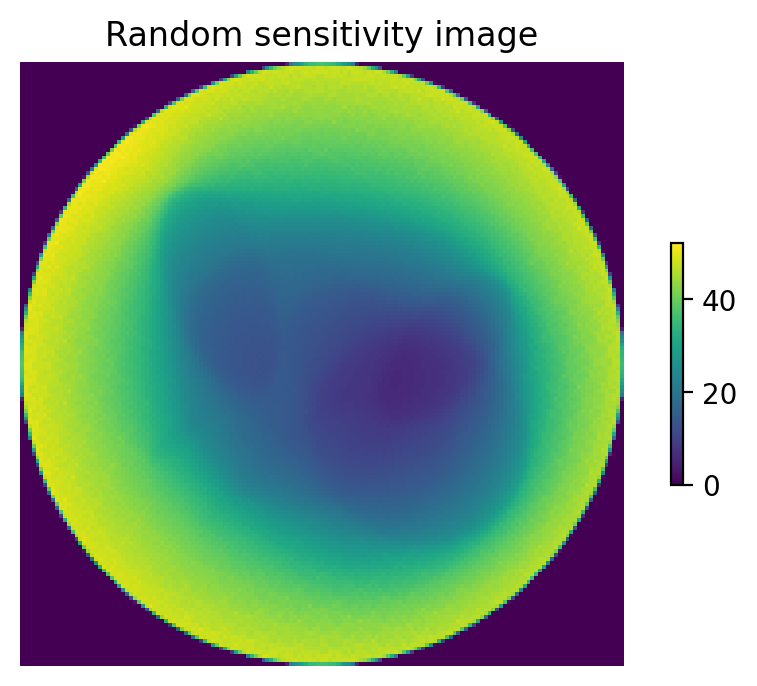

In [8]:
random_image = template_image.fill(random_image_array)
random_sens_image = get_sensitivity(random_image, template_sino)
plot_2d_image([1,1,1], random_sens_image.as_array()[0], "Random sensitivity image")

Right. So next we need some training data with a transformation. In order to do this we''l use an affine tranformation from

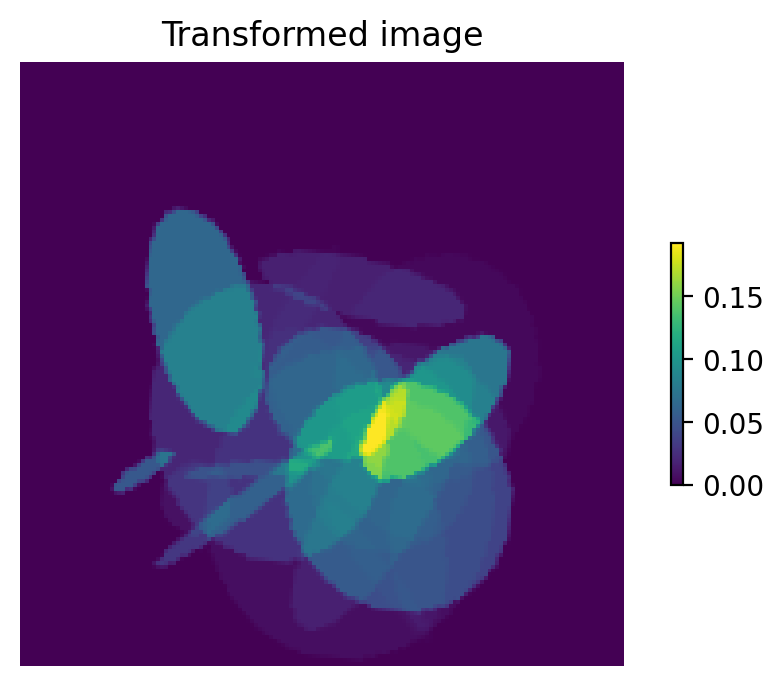

In [9]:
# rotate, scale, translate
theta, tx, ty, sx, sy = 0.1, 0.1, 0.1, 0.95, 0.95
transformed_image = affine_transform_2D_image(theta, tx, ty, sx, sy, random_image)
plot_2d_image([1,1,1], transformed_image.as_array()[0], "Transformed image")

And we can now find our sensitivity image to find the target data for training our model

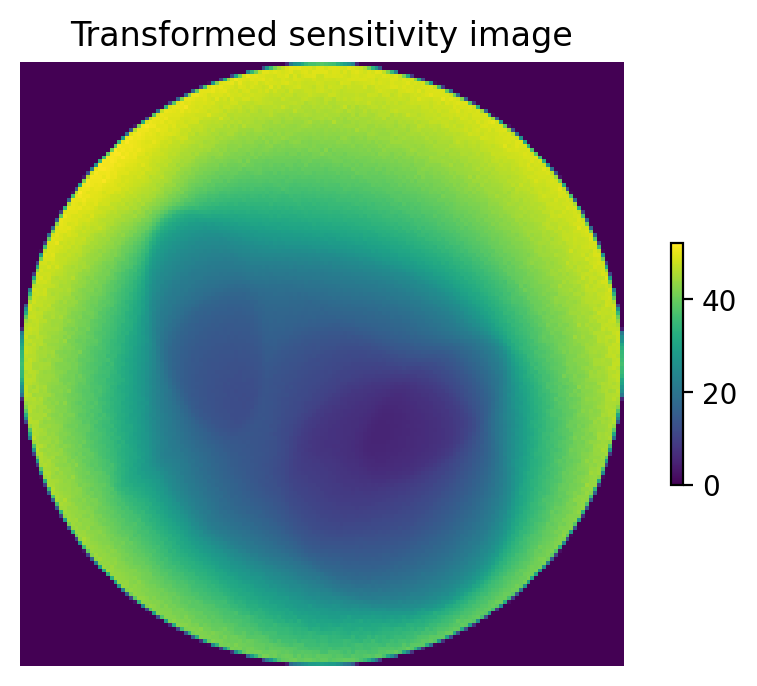

In [10]:
transformed_sens_image = get_sensitivity(transformed_image, template_sino)
plot_2d_image([1,1,1], transformed_sens_image.as_array()[0], "Transformed sensitivity image")

This is exactly what is happening in our Pytorch Data Loader

In [11]:
train_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, random_image, template_sino, mode="train", n_samples = 1) \
    , batch_size=1, shuffle=True)

In [12]:
# import numpy as np

# # Initialize lists to hold features and labels
# X_list = []
# y_list = []

# # Iterate over the DataLoader and save the features and labels
# for data in train_dataloader:
#     X, y = data
#     X_list.append(X.numpy())  # Convert tensors to numpy arrays before appending
#     y_list.append(y.numpy())

# # Convert lists to numpy arrays
# X_arr = np.concatenate(X_list, axis=0)
# y_arr = np.concatenate(y_list, axis=0)

# # Save the arrays
# np.save('/home/sirfuser/devel/share_data/X_train.npy', X_arr)
# np.save('/home/sirfuser/devel/share_data/y_train.npy', y_arr)

In [13]:
# # Load the arrays
# X_train = np.load('X_train.npy')
# y_train = np.load('y_train.npy')

# # Convert arrays to tensors
# X_train_tensor = torch.from_numpy(X_train)
# y_train_tensor = torch.from_numpy(y_train)

# # Create a TensorDataset and DataLoader
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [14]:
# valid_dataloader = torch.utils.data.DataLoader( \
#     EllipsesDataset(radon_transform, attn_image, template, mode="valid", n_samples = 4) \
#     , batch_size=mini_batch, shuffle=False)

# # Initialize lists to hold features and labels
# X_val_list = []
# y_val_list = []

# # Iterate over the DataLoader and save the features and labels
# for data in train_dataloader:
#     X, y = data
#     X_val_list.append(X.numpy())  # Convert tensors to numpy arrays before appending
#     y_val_list.append(y.numpy())

# # Convert lists to numpy arrays
# X_val_arr = np.concatenate(X_val_list, axis=0)
# y_val_arr = np.concatenate(y_val_list, axis=0)

# # Save the arrays
# np.save('/home/sirfuser/devel/share_data/X_val.npy', X_val_arr)
# np.save('/home/sirfuser/devel/share_data/y_val.npy', y_val_arr)

torch.Size([1, 3, 155, 155])
torch.Size([1, 2, 155, 155])


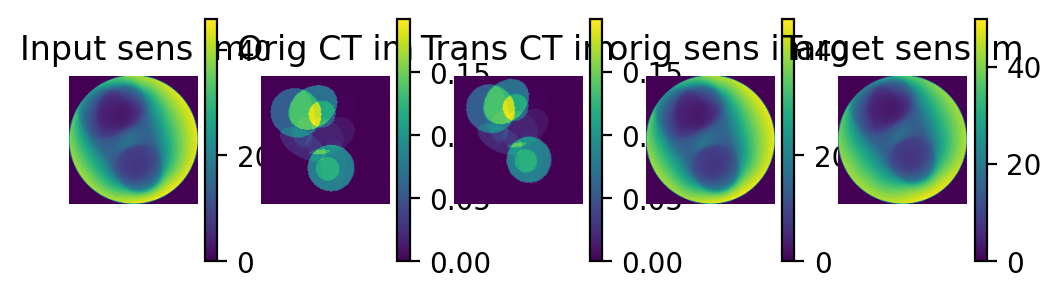

In [15]:
for data in train_dataloader:  # `data` is a batch of data
    X, y = data  # X is the batch of features, y is the batch of targets.
    print(X.size())
    print(y.size())
    plot_2d_image([1,5,1], X[0,0,:,:].numpy(), "Input sens im")
    plot_2d_image([1,5,2], X[0,1,:,:].numpy(), "Orig CT im")
    plot_2d_image([1,5,3], X[0,2,:,:].numpy(), "Trans CT im")
    plot_2d_image([1,5,4], y[0,0,:,:].numpy(), "orig sens im")
    plot_2d_image([1,5,5], y[0,1,:,:].numpy(), "Target sens im")
    


So we input a sensitivity image and a transformed CT image and output a transformed sensitivity image

## Things to think about
- Is this the best training data (how useful is a bunch of ellipses?) - I actually have a few more functions that could be useful, but I'll let you think about this first.
- Is this the best input / output (can we use difference images? How will our model have to change?)